# Building a CNN for CIFAR10 Dataset with PyTorch

## First Steps

In the following book we will generate a convolutional neural network (CNN) using pytorch for the classification trouble of CIFAR10, a dataset of 60,000 images of 32x32 with 10 different classes. Our goal is to generate a model capable of an accuracy of at least 70%.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We are importing libraries essential for the CIFAR10 Classification task.
<br><br>
    <b>Why:</b><br>
    The selected libraries offer tools and functionalities vital for data manipulation and implementing our classification task. We will use:
    <ul>
        <li><b>numpy:</b> Provides support for numerical operations, linear algebra, and ndarray creation.</li>
        <li><b>torch:</b> A deep learning framework we'll employ for designing and training neural networks.</li>
        <li><b>torchvision:</b> It offers popular datasets (including CIFAR10), pre-trained model architectures, and image transformations for computer vision tasks.</li>
        <li><b>matplotlib:</b> Allows us to visualize data through plots and graphs.</li>
        <li><b>os:</b> Offers functionalities to interface with the operating system, enabling tasks like reading datasets stored locally.</li>
    </ul><br>
    <b>How:</b><br>
    We'll import these libraries, ensuring they've been previously installed using a package manager such as pip or conda.
<br>
</div>


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

### Get CIFAR10 Dataset

As with all data problems, let's start with the data

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We will access the CIFAR10 dataset, and from it, generate training, validation, and testing datasets. During this step, we'll also normalize the dataset to streamline the process.
<br><br>
    <b>Why:</b><br>
    We will train our CNN using the training dataset. This training will be validated against the validation dataset. While this validation data is unfamiliar to the model, it helps us identify if our model is overfitting. Our goal is to achieve generalization. The test dataset provides a glimpse into the model's performance on entirely unknown data.
    <br><br>
    <b>How:</b><br>
    Using PyTorch's torchvision, we'll access the CIFAR10 dataset. Given that this dataset contains 60K images, we'll allocate portions of it for training, validation, and testing purposes.
<br><br>
</div>


In [2]:
# Variables
DATA_PATH = './'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

# Transform pipeline
transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
print('---Preparing training dataset---')
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True, transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
print('')

# Validation set
print('---Preparing validation dataset---')
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True, transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
print('')

# Test set
print('---Preparing test dataset---')
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))
print('')

---Preparing training dataset---
Files already downloaded and verified

---Preparing validation dataset---
Files already downloaded and verified

---Preparing test dataset---
Files already downloaded and verified



Next we will confirm that we have the training dataset with the normalization indicated and the size we defined above

In [3]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

### Computing Device

"PyTorch not only provides a robust framework that simplifies the development process, but it also offers the flexibility to choose among various computing engines. We can leverage NVIDIA CUDA, MPS for Metal processors in Mac [1], or default to CPU if neither is available. Utilizing the first two options enables better parallelization, yet the ability to switch to CPU ensures our solution is somewhat more architecturally agnostic.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We'll determine the optimal computing device.
<br><br>
    <b>Why:</b><br>
    Based on the hardware available for this exercise, we may have access to NVIDIA CUDA, Mac Metal, or just the CPU. By auto-detecting the best available option, we ensure efficient computation while avoiding issues on machines that might lack specific hardware requirements.
    <br><br>
    <b>How:</b><br>
    We'll first check for the availability of CUDA, then MPS (for Mac Metal). If neither is available, we'll default to using the CPU as the torch device.
<br><br>
</div>


In [4]:
# Select torch device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

mps


### Dataset Exploration

To provide more context to the task at hand, we'll use a function to display random 32x32 images from the test dataset (the images not seen during training). This will allow us to view both the image and its corresponding label. It's from images like these that our CNN will generate classifications.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We'll visualize random images from the CIFAR10 dataset.
<br><br>
    <b>Why:</b><br>
    To gain a deeper understanding of the dataset and the nature of the problem we're addressing.
    <br><br>
    <b>How:</b><br>
    We'll extract a 32x32 image, display it using matplotlib, and present its corresponding label, giving insight into a specific class and its representation within the dataset.
<br><br>
</div>

Image of a: ship


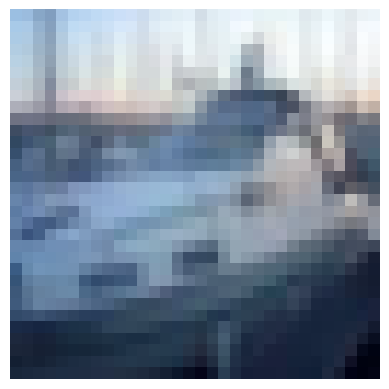

In [5]:
# get the classes
classes = test_loader.dataset.classes

# Function to plot images
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

# Take one random image and it's label
rnd_sample_idx = np.random.randint(len(test_loader))
print(f'Image of a: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


Next, we will display a grid featuring 8 images for each of the 10 classes in the CIFAR10 dataset, to better grasp the variety of images and their corresponding labels. The classes include: airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We'll display a comprehensive grid of images from each class in the CIFAR10 dataset.
<br><br>
    <b>Why:</b><br>
    To offer a broader view of the variety and characteristics of images within each class.
    <br><br>
    <b>How:</b><br>
    We'll create a 8x10 grid by iterating through the test dataset, showcasing 8 representative images for each of the 10 classes.
<br><br>
</div>


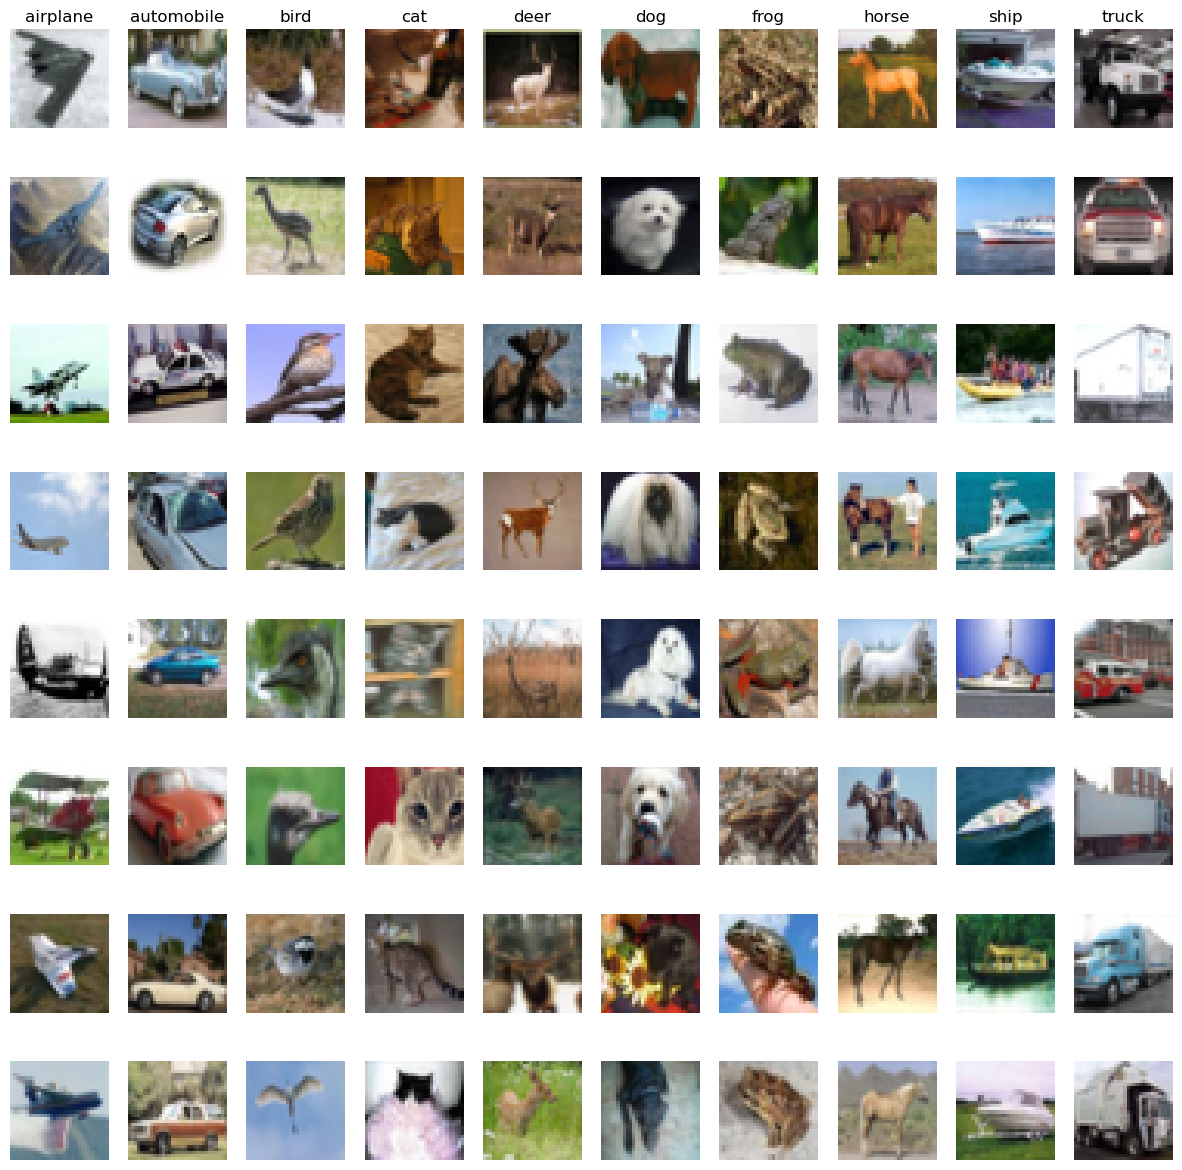

In [6]:
# Plot the whole grid
def plot_cifar10_grid():
    
    # Define grid
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    
    # Take classes and samples
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        
        # Plot the grid
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

## CNN Models

By now, we're familiar with the CIFAR10 dataset, its variety of images, and the classes we aim to predict. In the upcoming sections, we'll take several steps to develop our model:

1. Define an accuracy function to measure our model's performance.
2. Set up a training loop to train our models.
3. Establish a linear neural network model to serve as our baseline.
4. Develop a sequential Convolutional Neural Network (CNN) to potentially enhance our predictions.

This progression will allow us to contrast the efficacy of a basic linear neural network against the advantages of a convolutional approach, particularly in the realm of image recognition.

### Accuracy Function

Let's begin by crafting an accuracy function, which will indicate the proportion of images that were correctly labeled. Given that we have 10 distinct classes, random guessing would give us a 1/10, or 10%, chance of correctly identifying an image's class. Any accuracy rate significantly above this 10% threshold suggests that our model is adding value and performing its task effectively. Thus, our goal is to devise a function that quantifies the percentage of correctly identified labels.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We're creating an accuracy function to determine the percentage of images correctly classified.
    <br><br>
    <b>Why:</b><br>
    This function serves as a pivotal metric, enabling us to gauge our model's performance.
    <br><br>
    <b>How:</b><br>
    The function will compare the predicted labels against the actual labels from the dataset. By tallying the number of correct matches and then dividing by the total number of observations, we'll obtain our accuracy rate. For instance, if out of 10 images, 5 are correctly predicted, our accuracy is 50%. We'll represent this as a floating-point number, meaning 0.5 equates to 50%.
<br><br>
</div>

In [7]:
# Function for accuracy 
def accuracy(model, loader):
    # Hold values
    num_correct = 0
    num_total = 0
    
    #change to eval
    model.eval()
    model = model.to(device=device)
    
    # Evaluate the predicted vs the real classes
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        return float(num_correct)/num_total

### Training Loop

To train our neural network models (both the linear and the CNN), it's imperative to ensure that our data traverses the network layers. This allows the network to generate predictions, which are then evaluated against actual labels using a loss function, such as cross-entropy. The resulting error is used to adjust the model parameters through backpropagation, driven by an optimizer. While PyTorch provides the necessary tools to perform these operations, it's essential for us to craft a strategic training process.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We're crafting a function that guides the training process of our neural networks.
    <br><br>
    <b>Why:</b><br>
    This function is instrumental for our models' iterative learning. By understanding the nuances of the training data and adjusting parameters based on computed losses, we aim to enhance prediction accuracy.
    <br><br>
    <b>How:</b><br>
    The function utilizes the provided model, optimizer, and a number of epochs. For each epoch, data batches from the training dataset traverse the model. We subsequently compute the cross-entropy loss from the model's predictions. The backpropagation process then utilizes this loss to adjust the model parameters using the specified optimizer. At the end of each epoch, we measure the model's accuracy on a validation dataset to monitor its performance. As an adittional, we will include a chart of the loss and a chart of accuracy to also have a view of the graphical evolution of our model.
<br><br>
</div>


In [8]:
def train(model, optimiser, epochs=100):
    
    # Hold costs and accuracies
    costs = []
    accuracies = []
    
    # Trainning loop
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
        acc = accuracy(model, val_loader)
        
        # Save costs and accuracies
        costs.append(cost.item())
        accuracies.append(acc)

        print(f'Epoch: {epoch}, cost: {cost.item()}, accuracy: {acc},')
        
    # Plot the training evolution using a 1x2 grid
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the cost on the first subplot
    ax1.plot(costs, color='tab:red', label='Cost')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Cost')
    ax1.set_title('Training Cost')
    ax1.legend()

    # Plot the accuracy on the second subplot
    ax2.plot(accuracies, color='tab:blue', label='Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_ylim(0, 1)
    ax2.legend()

    plt.tight_layout()
    plt.show()


### Linear Model

We have a trainning strategy, a goal and a strategy to measure success (accuracy), now let's create the first challenger, a simple linear neural network, that will give us the baseline to compara the gains (if any) of our CNN approach.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We will create a linear neural network, train it and generate a baseline of what we can achieve with this technique for the CIFAR10 classification problem.
<br><br>
    <b>Why:</b><br>
    This will help us to create comparissons with the CNN strategy.
    <br><br>
    <b>How:</b><br>
    We will use PyTorch and two hidden layers with ReLU on a fully connected neural network. Our entry 
<br><br>
</div>

In [9]:
# Simple base model
hidden = 256
hidden1 = 256
lr = 0.001
epochs = 10
model1 = nn.Sequential(nn.Flatten(),
                       nn.Linear(in_features=32*32*3, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=10))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

Epoch: 0, cost: 1.3539592027664185, accuracy: 0.4736,
Epoch: 1, cost: 1.8594483137130737, accuracy: 0.4954,
Epoch: 2, cost: 2.276379108428955, accuracy: 0.51,
Epoch: 3, cost: 1.0664005279541016, accuracy: 0.5222,
Epoch: 4, cost: 0.9391219019889832, accuracy: 0.522,
Epoch: 5, cost: 0.9279384613037109, accuracy: 0.5208,
Epoch: 6, cost: 0.9359287023544312, accuracy: 0.5268,
Epoch: 7, cost: 1.097599983215332, accuracy: 0.5304,
Epoch: 8, cost: 0.8851027488708496, accuracy: 0.5474,
Epoch: 9, cost: 1.6022543907165527, accuracy: 0.5378,


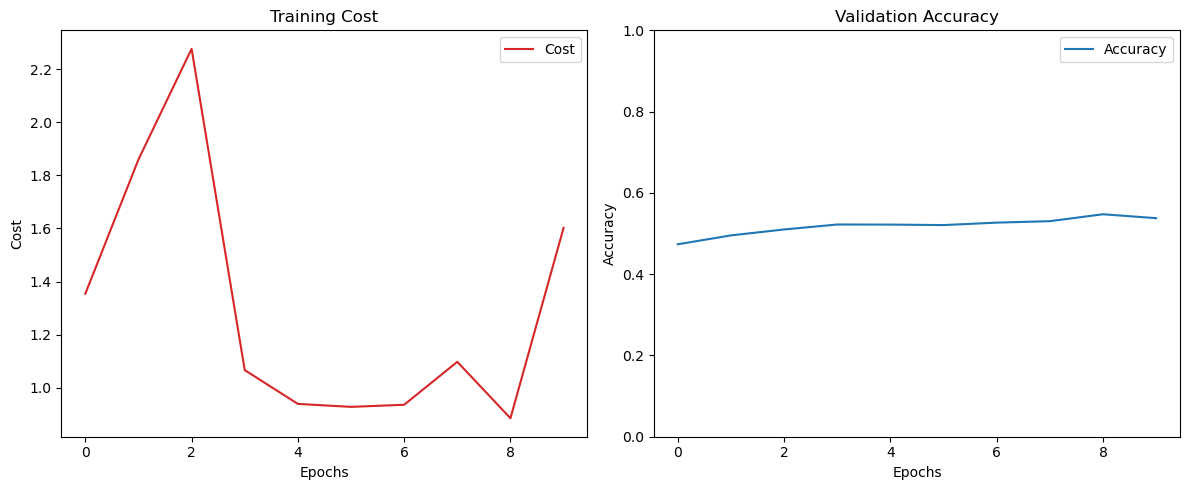

In [10]:
train(model1, optimiser, epochs)

### Sequential CNN

While our prior fully connected network, with its two hidden layers, was proficient in achieving a tad over 50% accuracy, our ambitions aim higher. To inch closer to our goal, we'll delve into convolutional neural networks (CNNs). We're poised to design three distinct CNN architectures, each offering its unique approach to the classification task. Through these experiments, we'll compare their respective performances and cherry-pick the best-performing model. This model will then be put to the test against the test dataset, ensuring that our chosen model not only performs well in theory but also in practice.

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We're set to design, train, and test three unique CNN architectures for the CIFAR10 Classification.
<br><br>
    <b>Why:</b><br>
    Our motivation is twofold: first, to surpass the benchmarks set by our previous models and second, to determine which architecture stands tall amongst the three. Once identified, the champion model will be pitted against the test dataset.
    <br><br>
    <b>How:</b><br>
    With our training and accuracy metrics as the bedrock, along with the power of PyTorch, we'll forge ahead with three CNN designs. Despite their unique architectures, each CNN will converge at a flattened layer, culminating in a softmax layer to facilitate cross-entropy calculations. They will be honed using the Adam optimizer. Though the complexity and depth will vary amongst them, our hypothesis suggests a direct correlation between a model's complexity and its ability to detect intricate features [2]. To ensure we aren't merely overfitting, we'll meticulously monitor performances on the validation datasets. The best-performing model on this validation set will subsequently be tested on the test dataset to validate our hypothesis.
<br><br>
</div>

In [11]:
import torch.nn as nn
import torch.optim as optim

# Shared parameters
epochs = 10
kernel_size = 3
initial_channels = 3

# CNN1
channel1_1 = 16
channel2_1 = 32
lr_1 = 0.0001
CNN1 = nn.Sequential(
    nn.Conv2d(initial_channels, channel1_1, kernel_size, padding=1),
    nn.ReLU(),
    nn.Conv2d(channel1_1, channel2_1, kernel_size, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16*16*channel2_1, 10)
)
optimiser1 = optim.Adam(CNN1.parameters(), lr_1)

# CNN2
channel1_2 = 16
channel2_2 = 32
channel3_2 = 32
channel4_2 = 16
lr_2 = 0.001
CNN2 = nn.Sequential(
    nn.Conv2d(initial_channels, channel1_2, kernel_size, padding=1),
    nn.ReLU(),
    nn.Conv2d(channel1_2, channel2_2, kernel_size, padding=1),
    nn.ReLU(),
    nn.Conv2d(channel2_2, channel3_2, kernel_size, padding=1),
    nn.ReLU(),
    nn.Conv2d(channel3_2, channel4_2, kernel_size, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16*16*channel4_2, 10)
)
optimiser2 = optim.Adam(CNN2.parameters(), lr_2)

# CNN3
channel1_3 = 32
channel2_3 = 64
channel3_3 = 64
lr_3 = 0.001
CNN3 = nn.Sequential(
    nn.Conv2d(initial_channels, channel1_3, kernel_size, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(channel1_3, channel2_3, kernel_size, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(channel2_3, channel3_3, kernel_size, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(channel3_3 * 8 * 8, 64),
    nn.Linear(64, 10)
)
optimiser3 = optim.Adam(CNN3.parameters(), lr_3)


### CNN 1

For the first model, we will use initial_channels of 3, channel1_1 of 16, channel2_1 of 32, and a learning rate lr_1 of 0.0001. This is a simple model with just two convolutional layers, each followed by a ReLU activation function, and eventually leading to a fully connected layer.

Epoch: 0, cost: 1.2829010486602783, accuracy: 0.4736,
Epoch: 1, cost: 1.1062586307525635, accuracy: 0.5134,
Epoch: 2, cost: 1.31614089012146, accuracy: 0.5492,
Epoch: 3, cost: 1.3402388095855713, accuracy: 0.5666,
Epoch: 4, cost: 0.6767413020133972, accuracy: 0.5686,
Epoch: 5, cost: 1.2978938817977905, accuracy: 0.5846,
Epoch: 6, cost: 0.9748309850692749, accuracy: 0.5994,
Epoch: 7, cost: 1.2913048267364502, accuracy: 0.6012,
Epoch: 8, cost: 0.9301926493644714, accuracy: 0.6156,
Epoch: 9, cost: 0.9405969381332397, accuracy: 0.6256,


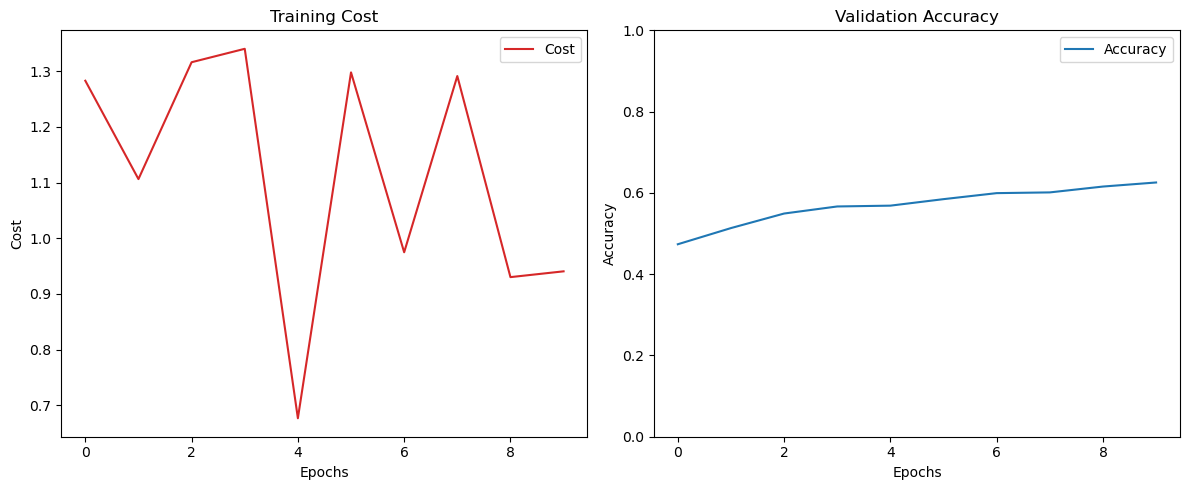

In [12]:
train(CNN1, optimiser1, epochs)

This model outcomes the base model with a good improvement overtime in accuracy, however the cost function has ups and downs which might be an indication that we need to still solve something as we are not consistently become better in general.

### CNN 2

For the second model, we will use initial_channels of 3, channel1_2 of 16, channel2_2 of 32, channel3_2 of 32, and channel4_2 of 16 with a higher learning rate lr_2 of 0.001. This model has more hidden layers, totaling four convolutional layers. Each of these layers is accompanied by a ReLU activation function. The architecture is aimed to see if increasing the complexity in layers paired with a higher learning rate would benefit the performance.

Epoch: 0, cost: 1.2684037685394287, accuracy: 0.5644,
Epoch: 1, cost: 0.8738189339637756, accuracy: 0.6262,
Epoch: 2, cost: 0.7470049262046814, accuracy: 0.6576,
Epoch: 3, cost: 0.3062722682952881, accuracy: 0.6756,
Epoch: 4, cost: 0.8335525989532471, accuracy: 0.6734,
Epoch: 5, cost: 0.2208998203277588, accuracy: 0.6838,
Epoch: 6, cost: 0.9915067553520203, accuracy: 0.6866,
Epoch: 7, cost: 0.5699875354766846, accuracy: 0.6868,
Epoch: 8, cost: 0.37686800956726074, accuracy: 0.676,
Epoch: 9, cost: 0.5449041724205017, accuracy: 0.6802,


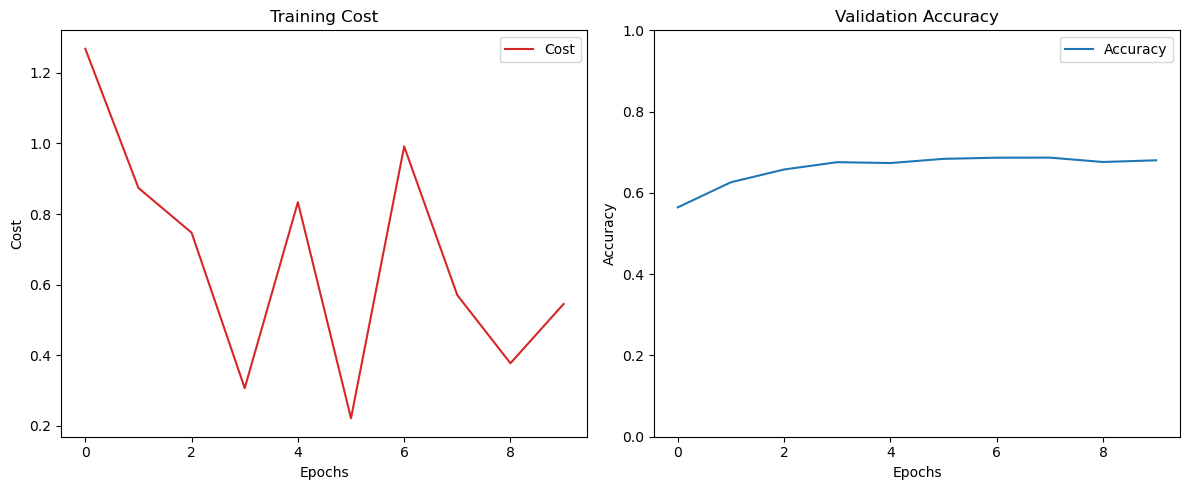

In [13]:
train(CNN2, optimiser2, epochs)

For this model that is more complex we see a good evolution but a recover in the cost; the accuracy evolve quickly but it genertes backs and forths.

### CNN 3

For the third model, we will increase the complexity from the first one but maintain a design that is less intricate than the second model. This model has initial_channels of 3, channel1_3 of 32, channel2_3 of 64, and channel3_3 of 64, with a learning rate lr_3 of 0.001. It has three convolutional layers, each of which is followed by a ReLU activation function, with the first two also followed by max-pooling.



Epoch: 0, cost: 0.8568739891052246, accuracy: 0.6206,
Epoch: 1, cost: 0.6393316984176636, accuracy: 0.6838,
Epoch: 2, cost: 0.7698696851730347, accuracy: 0.7162,
Epoch: 3, cost: 0.5549337863922119, accuracy: 0.7288,
Epoch: 4, cost: 0.5358021855354309, accuracy: 0.7206,
Epoch: 5, cost: 0.12929615378379822, accuracy: 0.7374,
Epoch: 6, cost: 0.5794932842254639, accuracy: 0.7312,
Epoch: 7, cost: 0.1722913682460785, accuracy: 0.727,
Epoch: 8, cost: 0.33208829164505005, accuracy: 0.7306,
Epoch: 9, cost: 0.37543338537216187, accuracy: 0.7344,


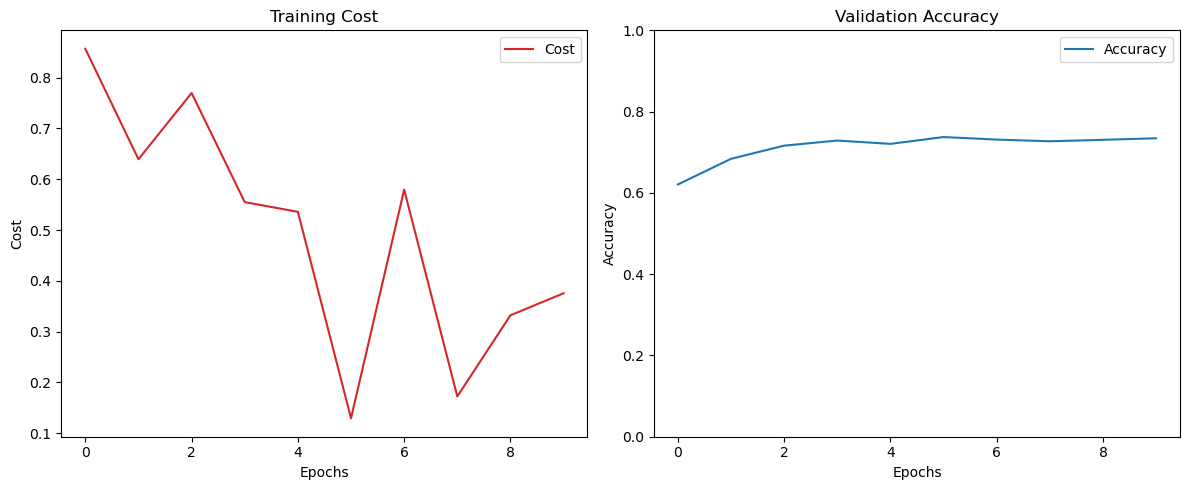

In [14]:
train(CNN3, optimiser3, epochs)

Of the 3 models this is the more satisfactory in terms of evolution, it goes after some epochs down in loss and the accuracy is evolving approaching nearly the 75%.

### Model comparison

Next let's compare our results

<div style="border:2px solid #1E90FF; padding:15px; margin-top:5px; margin-bottom:5px; border-radius:15px; box-shadow:4px 4px 12px #aaa; background-color:#E6E6FA; font-family:'Comic Sans MS', 'Chalkboard SE', 'Comic Neue', cursive; color:#333;">
    <h4 style="margin-top:0;">Code Documentation</h4>
    <b>What:</b><br>
    We will compare on a graphic the base model and the 3 CNN models with the test dataset in terms of accuracy.
<br><br>
    <b>Why:</b><br>
    This will allow us to make the comparison of the gains in these models and which one was best.
    <br><br>
    <b>How:</b><br>
    We will pass the test data vs the models and compute the accuracy, take thosse scores and create a bar chart with that information.
<br><br>
</div>

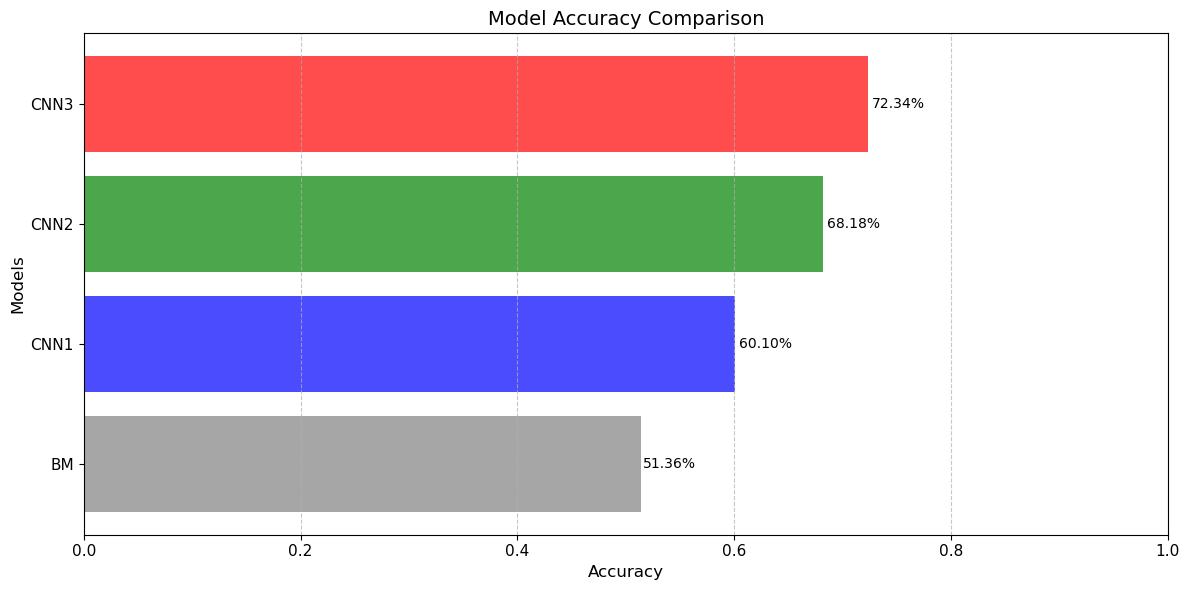

In [15]:
# Models
models = {"BM": model1, "CNN1": CNN1, "CNN2": CNN2, "CNN3": CNN3}
accuracies = {}

for name, model in models.items():
    acc = accuracy(model, test_loader)
    accuracies[name] = acc

# Plotting
names = list(accuracies.keys())
values = list(accuracies.values())
colors = ["grey", "blue", "green", "red"]

plt.figure(figsize=(12,6))
bars = plt.barh(names, values, color=colors, alpha=0.7)

# Annotating bars with their accuracy values
for bar in bars:
    width = bar.get_width()
    plt.text(1.005*width, 
             bar.get_y() + bar.get_height()/2, 
             '%.2f' % (width * 100) + '%', 
             ha='left', 
             va='center',
             fontsize=10)

# Enhancing the visual
plt.xlim([0, 1])
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7, zorder=0)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

plt.show()


And now let's see a result back from our model

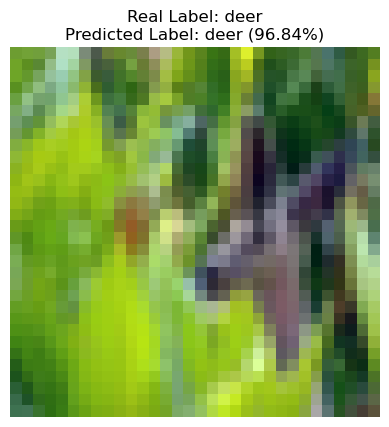

In [17]:
def plot_figure(image, true_label, pred_label, prob):
    plt.imshow(np.transpose(image, (1, 2, 0)))
    
    title_str = f"Real Label: {true_label}\nPredicted Label: {pred_label} ({prob:.2%})"
    plt.title(title_str, fontsize=12)
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader.dataset))

# Fetch image and true label
image, true_label = test_loader.dataset[rnd_sample_idx]
true_label_str = classes[true_label]

# Preprocess image for model prediction
image_unnormalized = (image - image.min()) / (image.max() - image.min())
image_for_model = image_unnormalized.unsqueeze(0).to(device)

# Predict using CNN3
outputs = CNN3(image_for_model)
probabilities = torch.nn.functional.softmax(outputs, dim=1)
predicted_class = torch.argmax(probabilities)
predicted_prob = probabilities[0][predicted_class].item()

# Display image with real and predicted labels
plot_figure(image_unnormalized, true_label_str, classes[predicted_class], predicted_prob)

## Conclusions

In this notebook we explore the problem of CIFAR10 classification using CNN and a linear model for baseline using PyTorch. After experimentation, it's clear that the choice of neural network type and its architecture matter greatly for image classification. Our initial linear model gave us a basic understanding, but the shift to Convolutional Neural Networks (CNNs) provided noticeable improvements in accuracy.

Of the three CNN architectures, each had distinct characteristics. Some were simpler with fewer convolutional layers, while others were more layered and complex. These experiments emphasized that while CNNs are suited for image tasks, the specific architecture and hyperparameters are pivotal.

Learning rate and epochs directly affect the model's training efficiency. Similarly, the number of layers in a CNN can influence the accuracy due to better feature extraction. However, more layers might lead to overfitting, reducing the model's effectiveness on new data.

In summary, for image classification tasks like CIFAR10, while CNNs offer advantages, it's the combination of architecture and hyperparameters that determine the actual performance. Through our tests, it became evident that strategic decisions and iterative fine-tuning are essential for optimal results.

## References

[1] Apple Inc. "PyTorch for Metal." Developer Apple. [Online]. Available: https://developer.apple.com/metal/pytorch/. (Accessed: 14-Oct-2023).

[2] M. D. Zeiler and R. Fergus, “Visualizing and Understanding Convolutional Networks,”, 2013. Available: http://arxiv.org/abs/1311.2901. (Accessed: 14-Oct-2023)

======================== End of Activity ========================